### Sedaro API "Rolling Simulations" Example

This notebook shows a powerful use case of the Sedaro API where simulations are started and terminated on a rolling basis to inject incremental state corrections (i.e. from telemetry) over time.

This is particularly useful to operations use cases where telemetry can tune the simulation to match the real system(s) - enabling the simulation to predict future performance and fill telemetry gaps.

#### Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current work and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

In [1]:
import json
from datetime import datetime
import time

import requests
import matplotlib.pyplot as plt
from sedaro import SedaroApiClient, SedaroSimulationResult
from IPython import display
from tabulate import tabulate

In [2]:
# Settings
with open('./secrets.json', 'r') as file:
    API_KEY = json.load(file)['API_KEY']

with open('./config.json', 'r') as file:
    config = json.load(file)

# Obtain these IDs from the branch list within each repository and add to config.json
AGENT_TEMPLATE_BRANCH_ID = config['AGENT_TEMPLATE_BRANCH_ID']    # ID of the Wildfire vehicle template branch
SCENARIO_BRANCH_ID = config['SCENARIO_BRANCH_ID']                # ID of the Wildfire scenario template branch
HOST = config['HOST']                                            # Sedaro instance URL
WILDFIRE_AGENT_ID = 'NT06aqHUT5djI1_JPAsck'
WILDFIRE_FLIGHT_COMPUTER_ID = 'NT4VO8jS_HPyoLi2pu1tF'

In [3]:
# Utils

def now_mjd():
    return datetime.utcnow().timestamp() / 86400 + 40587

def mjd_to_datetime(mjd):
    return datetime.utcfromtimestamp(round((mjd - 40587) * 86400))

#### Start a Simulation

Start a simulation from "now" for 2 hours into the future. 

This simulation is initialized using the latest TLE for the ISS from CelesTrak.  Before the simulation begins, Sedaro will propagate this TLE forward to the start time of the simulation.

In [4]:
# Get latest TLEs from CelesTrak
response = requests.get('https://celestrak.org/NORAD/elements/gp.php?GROUP=stations&FORMAT=tle')
iss_tle = '\n'.join(response.text.split('ISS (ZARYA)')[1].split('\r\n')[1:3])
print('Using TLE:')
print(iss_tle)

Using TLE:
1 25544U 98067A   23129.52382288  .00015688  00000+0  28157-3 0  9998
2 25544  51.6404 160.1596 0006193 328.0352 127.9636 15.50062205395795


In [5]:
with SedaroApiClient(api_key=API_KEY, host=HOST) as sedaro_client:
    scenario = sedaro_client.get_branch(SCENARIO_BRANCH_ID)
    wildfire_agent_template = sedaro_client.get_branch(AGENT_TEMPLATE_BRANCH_ID)
    
    # Update Wildfire's orbit
    wildfire_agent = scenario.Agent.get(WILDFIRE_AGENT_ID)
    wildfire_agent.orbit.update(
        initialStateDefType='TLE',
        initialStateDefParams={ 'tle': iss_tle },
    )

    # Update simulation clock config
    start = now_mjd()
    stop = start + 60*2/60/24 # 2 hour offset
    clock = scenario.ClockConfig.get(scenario.data['clockConfig'])
    clock.update(
        startTime=start,
        stopTime=stop,
    )

    # Start simulation
#     sim = sedaro_client.get_sim_client(SCENARIO_BRANCH_ID)
#     sim.start()

# print('Simulation started')

In [6]:
wildfire_battery = wildfire_agent_template.Battery.get_first()
wildfire_flight_computer = wildfire_agent_template.Component.get(WILDFIRE_FLIGHT_COMPUTER_ID)

def view_results():
    def fetch(tries=0):
        try:
            return SedaroSimulationResult.get_scenario_latest(API_KEY, SCENARIO_BRANCH_ID, host=HOST)
        except KeyboardInterrupt as e:
            raise e
        except:
            if tries < 5:
                print(f'No results yet.  Retrying after 10s... ({tries+1}/5)')
                time.sleep(10)
                return fetch(tries+1)
            raise ValueError(f'Failed to fetch results after {tries} tries')
    results = fetch()
    return results

results = view_results()
wildfire_results = results.agent('Wildfire')
root_results = wildfire_results.block('root')
battery_results = wildfire_results.block(wildfire_battery.id)


In [8]:


for _ in range(100):
    display.clear_output(wait=True)

    # now = 60074.093576829524
    now = now_mjd()

    print(f'Current Telemetry @ {mjd_to_datetime(now)} UTC (Simulated):\n')
    print(tabulate(
        [
            ('Battery SoC', battery_results.soc.value_at(now)),
            ('Battery Voltage', battery_results.voltage.value_at(now), 'V'),
            ('Battery Current', battery_results.current.value_at(now), 'A'),
        ],
        ['Label', 'Value', 'Units'],
        tablefmt="github"
    ))

    # common = {
    #     'linewidth': 1, 
    #     'elapsed_time': False, 
    #     'height': 2, 
    #     'xlim': [start, now] # CONFIG: Toggle this off to see all available past and future data
    # }
    # root_results.position.eci.plot(**common, ylabel='ECI Position', label=['X', 'Y', 'Z'])
    # for pack in wildfire_battery.packs:
    #     wildfire_results.block(pack.id).temperature.degC.plot(
    #         **common, 
    #         show=False, 
    #         label=pack.name
    #     )
    # wildfire_results.block(wildfire_flight_computer.id).temperature.degC.plot(
    #     **common, 
    #     ylabel='Temperatures [C]', 
    #     label=wildfire_flight_computer.name, 
    #     color='g'
    # )
    # battery_results.soc.plot(**common, ylabel='Battery SoC', color='m')
    # battery_results.voltage.plot(**common, ylabel='Battery Voltage [V]', color='c')
    # battery_results.current.plot(**common, ylabel='Battery Current [A]')

    time.sleep(0.5)

# for i in range(10):
#     display.clear_output(wait=True)
#     view_results()


Current Telemetry @ 2023-05-10 04:30:10 UTC (Simulated):

| Label           |     Value | Units   |
|-----------------|-----------|---------|
| Battery SoC     |  0.838671 |         |
| Battery Voltage | 27.307    | V       |
| Battery Current |  3.37961  | A       |


Current Telemetry @ 2023-05-10 02:14:45 UTC (Simulated):

| Label               |    Value | Units   |
|---------------------|----------|---------|
| Battery SoC         |  0.8     |         |
| Battery Voltage [V] | 27.1177  | V       |
| Battery Current [A] |  6.56169 | A       |


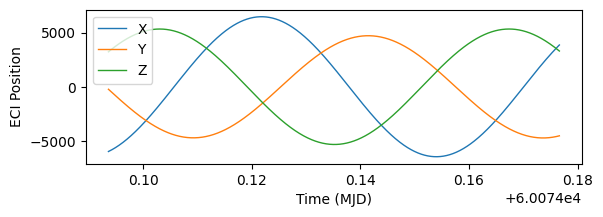

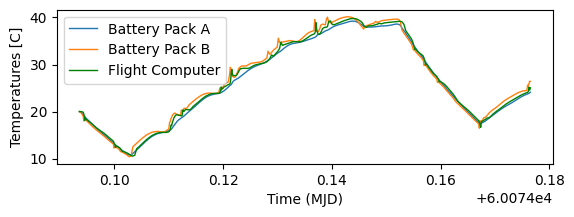

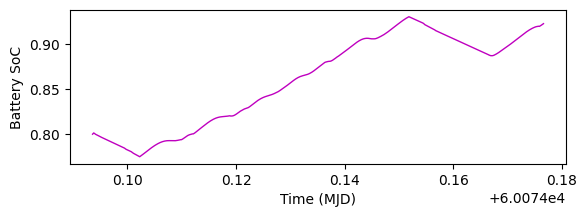

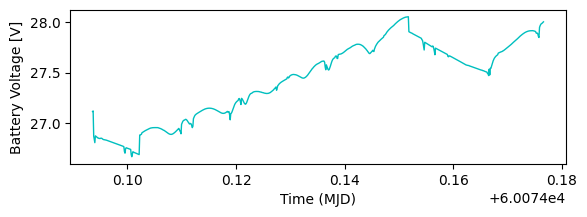

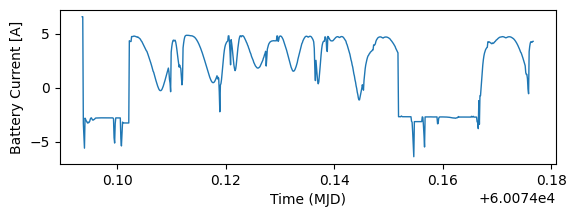

In [41]:

wildfire_results = results.agent('Wildfire')
root_results = wildfire_results.block('root')
battery_results = wildfire_results.block(wildfire_battery.id)

now = 60074.093576829524

print(f'Current Telemetry @ {mjd_to_datetime(now)} UTC (Simulated):\n')
print(tabulate(
    [
        ('Battery SoC', battery_results.soc.value_at(now)),
        ('Battery Voltage [V]', battery_results.voltage.value_at(now), 'V'),
        ('Battery Current [A]', battery_results.current.value_at(now), 'A'),
    ],
    ['Label', 'Value', 'Units'],
    tablefmt="github"
))

common = {'linewidth': 1, 'elapsed_time': False, 'height': 2}
root_results.position.eci.plot(**common, ylabel='ECI Position', label=['X', 'Y', 'Z'])
for pack in wildfire_battery.packs:
    wildfire_results.block(pack.id).temperature.degC.plot(
        **common, 
        show=False, 
        label=pack.name
    )
wildfire_results.block(wildfire_flight_computer.id).temperature.degC.plot(
    **common, 
    ylabel='Temperatures [C]', 
    label=wildfire_flight_computer.name, 
    color='g'
)
battery_results.soc.plot(**common, ylabel='Battery SoC', color='m')
battery_results.voltage.plot(**common, ylabel='Battery Voltage [V]', color='c')
battery_results.current.plot(**common, ylabel='Battery Current [A]')

# for i in range(1):
#     display.clear_output(wait=True)
#     view_results()

#### Restart Simulation from Latest Telemetry

If the simulation is still running, first terminate it.

In [8]:
with SedaroApiClient(api_key=API_KEY, host=HOST) as sedaro_client:
    # Instantiate API and scenario objects
    sim = sedaro_client.get_sim_client(SCENARIO_BRANCH_ID)

    # Start scenario and wait for it to finish, then get data
    sim.start()
    results = SedaroSimulationResult.get_scenario_latest(API_KEY, SCENARIO_BRANCH_ID, host=HOST)

    # Summarize results
    results.summarize()

SedaroApiException: (400)
Reason: Array is empty. Please retry the query after a short wait.


In [ ]:
if results.success:
    for agent_name in results.templated_agents:
        agent_results = results.agent(agent_name)
        if sensor.id in agent_results:
            # Select sensor results and show summary
            sensor_result = agent_results.block(sensor.id)
            sensor_result.summarize()

            # Plot Data
            sensor_result.measurement.rpm.plot(show=False, marker='.', markersize=2, linewidth=0)
            plt.ylabel('Angular Velocity (rpm)')
            plt.legend(['x', 'y', 'z'])
            plt.show()